# Yolo Detection 구현 : bus / trcuk detection

## 데이터셋 구축

### 캐글 데이터 받아오기

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import os
import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
import cv2
import json
import random
import shutil
import albumentations as A

from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from time import time
from ipywidgets import interact
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seonyong","key":"15cdbf608ae7dcc43e31d8ac3e790795"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!mkdir data/
%cd data

/content/data


In [6]:
!kaggle datasets download -d sixhky/open-images-bus-trucks

 99% 364M/367M [00:21<00:00, 19.4MB/s]
100% 367M/367M [00:21<00:00, 18.2MB/s]


In [7]:
!unzip -qq '/content/data/open-images-bus-trucks.zip'

### 데이터 확인

In [8]:
data_dir  = '/content/data/images'

In [9]:
# 데이터 전체 수
data_len = os.listdir(data_dir + '/images')
len(data_len)

15225

In [10]:
# x, y 좌표는 정규화 -> 원래 좌표 필요 -> yolo 포멧 맞추기
df = pd.read_csv('/content/data/df.csv')
df = df.loc[:, ['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,0000599864fd15b3,Bus,0.343750,0.908750,0.156162,0.650047
1,00006bdb1eb5cd74,Truck,0.276667,0.697500,0.141604,0.437343
2,00006bdb1eb5cd74,Truck,0.702500,0.999167,0.204261,0.409774
3,00010bf498b64bab,Bus,0.156250,0.371250,0.269188,0.705228
4,00013f14dd4e168f,Bus,0.287500,0.999375,0.194184,0.999062


In [11]:
# 데이터셋 비율 - 8:1:1
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(data_len) * split_ratio[0])
val_len = int(len(data_len) * split_ratio[1])
test_len = len(data_len) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

12180, 1522, 1523


In [12]:
# 데이터를 랜덤으로 섞고 길이에 따라서 데이터 나누기
data_list = (os.listdir(data_dir+'/images'))
random.shuffle(data_list) # data 섞기

train_img, val_img, test_img = [], [], []

for i in range(len(data_list)):
    if 0 <= i < train_len:
        train_img.append(data_list[i])
    elif train_len <= i < train_len + val_len:
        val_img.append(data_list[i])
    elif train_len + val_len <= i:
        test_img.append(data_list[i])

print('{}, {}, {}'.format(len(train_img), len(val_img), len(test_img)))

12180, 1522, 1523


In [13]:
!mkdir 'train' 'val' 'test'

In [14]:
# 8:1:1 비율로 각각의 폴더 안에 데이터 나누어 넣기
to_file_path = '/content/data/'
from_file_path = '/content/data/images/images/'

for idx, file_name in enumerate(os.listdir(from_file_path)):
    if 0 <= idx < train_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'train/' + file_name)
    elif train_len <= idx < train_len + val_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'val/' + file_name)
    elif train_len +  val_len <= idx:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'test/' + file_name)

print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


In [15]:
print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


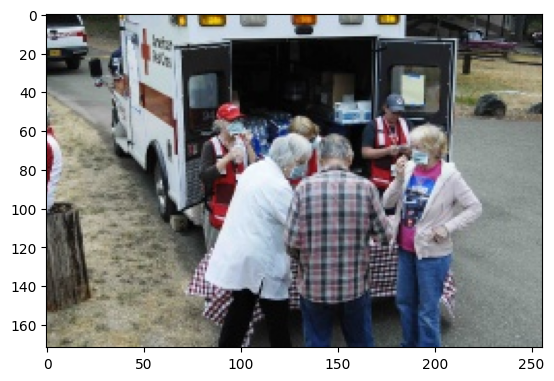

In [16]:
data_dir = '/content/data'

index = 205
file_name = os.listdir(data_dir + '/train')[index]
image = cv2.imread(os.path.join(data_dir, 'train', file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [17]:
image_id = file_name.split('.')[0]
image_id

'a66949ead28a5c24'

In [18]:
# 바운딩 box는 하나가 아닐 수도 있다
meta_data = df[df['ImageID'] == image_id]
meta_data

,ImageID,LabelName,XMin,XMax,YMin,YMax
16042,a66949ead28a5c24,Truck,0.10125,0.825625,0.016807,0.800187


In [19]:
label = meta_data['LabelName'].values
label

array(['Truck'], dtype=object)

In [20]:
# Normalize -> 원본 크기로 변환해야 할 필요가 있다.
boxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
print(boxes, type(boxes[0]))

[[0.10125  0.825625 0.016807 0.800187]] <class 'numpy.ndarray'>


In [21]:
CLASS_NAME_TO_ID = {'Bus':0, 'Truck':1}
CLASS_NAME_TO_ID

{'Bus': 0, 'Truck': 1}

In [22]:
CLASS_ID_TO_NAME = {0: 'Bus', 1: 'Truck'}
CLASS_ID_TO_NAME

{0: 'Bus', 1: 'Truck'}

In [23]:
class_ids = [CLASS_NAME_TO_ID[id] for id in label]
class_ids

[1]

In [25]:
img_H, img_W, _ = image.shape

unnorm_bboxes = boxes.copy()
unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]] # ymin, xmax 자리 바꿈
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2] # w, h 길이로
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2) # bounding box center 좌표
unnorm_bboxes[:, [0,2]] *= img_W
unnorm_bboxes[:, [1,3]] *= img_H

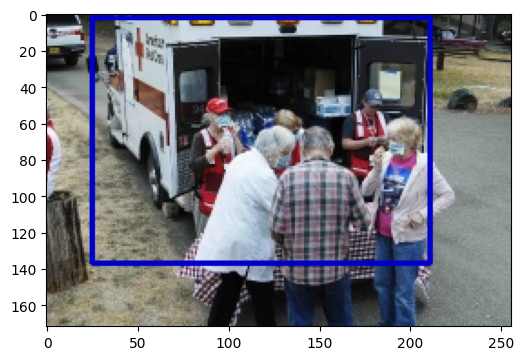

In [26]:
canvas = utils.visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [27]:
image_files = os.listdir(data_dir + '/train')

In [28]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('/content/data/train', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_id = image_file.split('.')[0]
    meta_data = df[df['ImageID'] == image_id]
    cate_names = meta_data["LabelName"].values
    bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values

    img_H, img_W, _ = image.shape

    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
    unnorm_bboxes[:, [0,2]] *= img_W
    unnorm_bboxes[:, [1,3]] *= img_H
    canvas = utils.visualize(image, unnorm_bboxes, class_ids)

    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()
    print(canvas.shape)

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

### 연산을 위한 텐서 변환

1. augmentation & dataset
2. dataloader

In [40]:
class MyDataset():
    def __init__(self, data_dir, phase, transform=None):
        self.data_dir = data_dir
        self.phase = phase
        self.df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # iamge, class_id, bounding box(xc, yc, w, h) 형식
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)

        if self.transform:
            transformed_data = transform(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])

            if len(class_ids) == 0:
                bboxes = np.array([[0., 0., 0., 0]], dtype=np.float32)
                class_ids = np.array([-1])

        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, filename

    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image

    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.df[self.df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])

        # 'XMin', 'XMax', 'YMin', 'YMax' -> X.center, Y.center, X.w, Y.h
        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]] # XMax, YMin 자리바꿈
        bboxes[:, 2:4] -= bboxes[:, 0:2] # XMax -> w, YMax -> h
        bboxes[:, 0:2] += bboxes[:, 2:4] / 2 # XMin -> x좌표 center, YMin -> y좌표 center
        return bboxes, class_ids

In [30]:
random.seed(29)

In [33]:
IMAGE_SIZE = 448
transform = A.Compose([
                        A.ShiftScaleRotate(rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, value=(127, 127, 127), p=0.5),
                        A.RandomSizedBBoxSafeCrop(height=IMAGE_SIZE, width=IMAGE_SIZE),
                        A.HorizontalFlip(p=0.5),
                        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1),
                        A.RandomBrightnessContrast(p=0.3),
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                        ToTensorV2()
                        ],
                      bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
                      )

In [47]:
dataset_n = MyDataset(data_dir=data_dir, phase='train', transform=None)
dataset_t = MyDataset(data_dir=data_dir, phase='train', transform=transform)

In [48]:
image, target, filename = dataset_t[0]

In [49]:
image.shape

(448, 448, 3)

In [50]:
target

array([[0.83715049, 0.66493685, 0.32425321, 0.3361955 , 0.        ],
       [0.51784814, 0.54040176, 0.47331848, 0.79605412, 0.        ],
       [0.24578044, 0.54455352, 0.0437111 , 0.0688277 , 0.        ],
       [0.17316996, 0.50783934, 0.05607005, 0.0740349 , 0.        ],
       [0.10364648, 0.47704106, 0.1094801 , 0.09021593, 0.        ]])

In [51]:
filename

'2ef4e67821b5d797.jpg'

In [55]:
@interact(index=(0, len(dataset_t)-1))
def show_sample(index=0):
    image1, target1, filename1 = dataset_n[index]
    img_H1, img_W1, _ = image1.shape

    image2, target2, filename2 = dataset_t[index]
    img_H2, img_W2, _ = image2.shape

    bboxes1 = target1[:, 0:4]
    class_ids1 = target1[:, 4]
    bboxes1[:, [0,2]] *= img_W1
    bboxes1[:, [1,3]] *= img_H1

    bboxes2 = target2[:, 0:4]
    class_ids2 = target2[:, 4]
    bboxes2[:, [0,2]] *= img_W2
    bboxes2[:, [1,3]] *= img_H2

    canvas1 = utils.visualize(image1, bboxes1, class_ids1)

    canvas2 = utils.visualize(image2, bboxes2, class_ids2)

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title('NORMAL')
    plt.imshow(canvas1)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Augmentation')
    plt.imshow(canvas2)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

In [56]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for i, t, f in batch:
        image_list.append(i)
        target_list.append(t)
        filename_list.append(f)

    return torch.stack(image_list, dim=0), target_list, filename_list

In [59]:
def build_dataloader(data_dir, batch_size, image_size):
    train_transform = A.Compose([
                            A.ShiftScaleRotate(rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, value=(127, 127, 127), p=0.5),
                            A.RandomSizedBBoxSafeCrop(height=image_size, width=image_size),
                            A.HorizontalFlip(p=0.5),
                            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1),
                            A.RandomBrightnessContrast(p=0.3),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()
                            ],
                        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
                        )
    val_transform = A.Compose([
                            A.Resize(height=image_size, width=image_size),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()
                            ],
                        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
                        )

    dataloaders = {}

    trainset = MyDataset(data_dir, phase='train', transform=train_transform)
    valset = MyDataset(data_dir, phase='val', transform=val_transform)
    testset = MyDataset(data_dir, phase='test', transform=val_transform)

    dataloaders['train'] = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloaders['val'] = DataLoader(valset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    dataloaders['test'] = DataLoader(testset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    return dataloaders

In [62]:
data_dir = '/content/data'
BATCH_SIZE = 4
IMAGE_SIZE = 448

dataloaders = build_dataloader(data_dir, BATCH_SIZE, IMAGE_SIZE)

In [64]:
for phase in ["train", "val", "test"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(f'-------------{phase}--------------')
        print(images.shape)
        print(targets)
        print(filenames)
        if index == 0:
            break

-------------train--------------
torch.Size([4, 3, 448, 448])
[array([[0.59522259, 0.48269008, 0.67616693, 0.64664617, 1.        ]]), array([[0.4980315 , 0.5       , 0.99606299, 1.        , 0.        ]]), array([[0.12217917, 0.59865104, 0.24435833, 0.80269792, 0.        ],
       [0.47450527, 0.48118438, 0.74630532, 0.95771946, 0.        ]]), array([[0.79581304, 0.59986545, 0.40837391, 0.61657345, 0.        ],
       [0.40877407, 0.62071869, 0.81544288, 0.71021334, 0.        ]])]
['7f8bd8e13c1c0714.jpg', 'b335d2d69ccb06c9.jpg', '7d0ae88b041d9287.jpg', 'b640e49b9079b2c9.jpg']
-------------val--------------
torch.Size([1, 3, 448, 448])
[array([[0.46831276, 0.49998865, 0.91917695, 0.97402694, 1.        ]])]
['533db6db1fffb0f9.jpg']
-------------test--------------
torch.Size([1, 3, 448, 448])
[array([[0.48906016, 0.49606299, 0.97812033, 0.99212598, 0.        ]])]
['4ade152b4a0dd06d.jpg']


## YOLOv1 아키텍처 구현

In [ ]:
# resnet18에서 layers 부분만 backbone, (avgpool, fc)는 사용 X
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
layers = [layer for layer in resnet18.children()]
layers, len(layers)

([Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

In [ ]:
test_backbone = nn.Sequential(*layers[:-2])

x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
out = test_backbone(x)
out.shape

torch.Size([1, 512, 14, 14])

In [ ]:
class YOLO_RESNET(nn.Module):
    def __init__(self, num_classes):
        super(YOLO_RESNET, self).__init__()

        self.num_classes = num_classes
        self.num_bboxes = 2
        self.grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained=True)
        layers = [layer for layer in resnet18.children()]

        self.backbone = nn.Sequential(*layers[:-2])
        self.neck = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
                                nn.Conv2d(in_channels=1024, out_channels=(4+1)*self.num_bboxes+self.num_classes, kernel_size=1, padding=0, bias=False),# yolo output depth
                                nn.AdaptiveAvgPool2d(output_size=(self.grid_size, self.grid_size))
        )

    def forward(self, x):
        out = self.backbone(x)
        out = self.neck(out)
        out = self.head(out) # (batch, 3, 448, 448) -> (batch, 12, 7, 7)

        return out

In [68]:
class YOLO_RESNET(nn.Module):
    def __init__(self, num_classes):
        super(YOLO_RESNET, self).__init__()

        self.num_classes = num_classes
        self.num_boxes = 2
        self.grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained=True)
        layers = [layer for layer in resnet18.children()]

        self.backbone = nn.Sequential(*layers[:-2])

        self.head = nn.Sequential(
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU(inplace=True),

                                    nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU(inplace=True),

                                    nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU(inplace=True),

                                    nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU(inplace=True),

                                    nn.Conv2d(in_channels=1024, out_channels=(1+4)*self.num_boxes+self.num_classes, kernel_size=1, padding=0, bias=False),
                                    nn.AdaptiveAvgPool2d(output_size=(self.grid_size, self.grid_size))

        )

    def forward(self, x):
        out = self.backbone(x)
        out = self.head(out)

        return out

In [69]:
NUM_CLASSES = 2
model = YOLO_RESNET(NUM_CLASSES)
model

YOLO_RESNET(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [70]:
x = torch.randn(1, 3, 448, 448)
out = model(x)
out.shape

torch.Size([1, 12, 7, 7])

In [71]:
BATCH_SIZE = 4
model = YOLO_RESNET(num_classes=NUM_CLASSES)

for index, batch in enumerate(dataloaders['train']):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    predictions = model(images)

    print(f'input shape: {images.shape} | output shape: {predictions.shape}')

    if index == 5:
        break

input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])


## YOLO Loss Function 구현

### Loss Function


In [78]:
class YOLO_LOSS():
    def __init__(self, num_classes, device, lambda_coord=5., lambda_noobj=0.5):
        self.num_classes = num_classes
        self.device = device
        self.grid_size = 7
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss(reduction="sum")

    def __call__(self, predictions, targets):
        self.batch_size, _, _, _ = predictions.shape
        groundtruths = self.build_batch_target_grid(targets)
        groundtruths = groundtruths.to(self.device)

        with torch.no_grad():
            iou1 = self.get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
            iou2 = self.get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])

        ious = torch.stack([iou1, iou2], dim=1)
        max_iou, best_box = ious.max(dim=1, keepdim=True)
        max_iou = torch.cat([max_iou, max_iou], dim=1)
        best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

        predictions_ = predictions[:, :5*2, ...].reshape(self.batch_size, 2, 5, self.grid_size, self.grid_size)
        obj_pred = predictions_[:, :, 0, ...]
        xy_pred = predictions_[:, :, 1:3, ...]
        wh_pred = predictions_[:, :, 3:5, ...]
        cls_pred = predictions[:, 5*2:, ...]

        groundtruths_ = groundtruths[:, :5, ...].reshape(self.batch_size, 1, 5, self.grid_size, self.grid_size)
        obj_target = groundtruths_[:, :, 0, ...]
        xy_target = groundtruths_[:, :, 1:3, ...]
        wh_target= groundtruths_[:, :, 3:5, ...]
        cls_target = groundtruths[:, 5:, ...]

        positive = obj_target * best_box

        obj_loss = self.mse_loss(positive * obj_pred, positive * ious)
        noobj_loss = self.mse_loss((1 - positive) * obj_pred, ious*0)
        xy_loss = self.mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2) * xy_target)
        wh_loss = self.mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                                positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
        cls_loss = self.mse_loss(obj_target * cls_pred, cls_target)

        obj_loss /= self.batch_size
        noobj_loss /= self.batch_size
        bbox_loss = (xy_loss+wh_loss) / self.batch_size
        cls_loss /= self.batch_size

        total_loss = obj_loss + self.lambda_noobj*noobj_loss + self.lambda_coord*bbox_loss + cls_loss
        return total_loss, (obj_loss.item(), noobj_loss.item(), bbox_loss.item(), cls_loss.item())

    def build_target_grid(self, target):
        target_grid = torch.zeros((1+4+self.num_classes, self.grid_size, self.grid_size), device=self.device)

        for gt in target:
            xc, yc, w, h, cls_id = gt

            if cls_id == -1:
                return target_grid

            xn = (xc % (1/self.grid_size))
            yn = (yc % (1/self.grid_size))
            cls_id = int(cls_id)

            i_grid = int(xc * self.grid_size)
            j_grid = int(yc * self.grid_size)
            target_grid[0, j_grid, i_grid] = 1
            target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn,yn,w,h])
            target_grid[5+cls_id, j_grid, i_grid] = 1

        return target_grid

    def build_batch_target_grid(self, targets):
        target_grid_batch = torch.stack([self.build_target_grid(target) for target in targets], dim=0)
        return target_grid_batch

    def get_IoU(self, cbox1, cbox2):
        box1 = self.xywh_to_xyxy(cbox1)
        box2 = self.xywh_to_xyxy(cbox2)

        x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
        y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
        x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
        y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

        intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
        union = abs(cbox1[:, 2, ...]*cbox1[:, 3, ...]) + \
                abs(cbox2[:, 2, ...]*cbox2[:, 3, ...]) - intersection

        intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
        return intersection

    def generate_xy_normed_grid(self):
        y_offset, x_offset = torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size))
        xy_grid = torch.stack([x_offset, y_offset], dim=0)
        xy_normed_grid = xy_grid / self.grid_size
        return xy_normed_grid.to(self.device)

    def xywh_to_xyxy(self, bboxes):
        xy_normed_grid = self.generate_xy_normed_grid()
        xcyc = bboxes[:,0:2,...] + xy_normed_grid.tile(self.batch_size, 1,1,1)
        wh = bboxes[:,2:4,...]
        x1y1 = xcyc - (wh/2)
        x2y2 = xcyc + (wh/2)
        return torch.cat([x1y1, x2y2], dim=1)

In [79]:
data_dir = '/content/data'
is_cuda = True

BATCH_SIZE = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

trainset = MyDataset(data_dir=data_dir, phase="train", transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
model = YOLO_RESNET(num_classes=NUM_CLASSES).to(DEVICE)
criterion = YOLO_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4)

for index, batch in enumerate(trainloader):
    images = batch[0].to(DEVICE)
    targets = batch[1]
    filenames = batch[2]

    predictions = model(images)
    loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if index % 1 == 0:
        print(loss,'\t|', obj_loss,'\t|',  noobj_loss,'\t|',  bbox_loss,'\t|',  cls_loss)

    if index == 10:
        break

tensor(32.5481, device='cuda:0', grad_fn=<AddBackward0>) 	| 1.055709719657898 	| 13.913314819335938 	| 4.458044528961182 	| 2.245551109313965
tensor(8.1360, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.21711766719818115 	| 5.919680595397949 	| 0.7550154328346252 	| 1.1840041875839233
tensor(6.6473, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.05873780697584152 	| 5.127309799194336 	| 0.6431180834770203 	| 0.809288501739502
tensor(9.8288, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.2067057192325592 	| 5.421781539916992 	| 1.151424765586853 	| 1.1540607213974
tensor(4.6485, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.07526914030313492 	| 5.000272274017334 	| 0.2734391689300537 	| 0.7058635354042053
tensor(4.7749, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.3276345133781433 	| 5.324406623840332 	| 0.22367537021636963 	| 0.6666465997695923
tensor(7.7590, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.22134259343147278 	| 3.93987774848938 	| 0.8256384134292603 	| 1.4395432472229004
t

## Training

In [81]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = defaultdict(float)
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1]
            filenames = batch[2]

            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(images)
            loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss['total_loss'] += loss.item()
                running_loss['obj_loss'] += obj_loss
                running_loss['noobj_loss'] += noobj_loss
                running_loss['bbox_loss'] += bbox_loss
                running_loss['cls_loss'] += cls_loss

                train_loss['total_loss'] += loss.item()
                train_loss['obj_loss'] += obj_loss
                train_loss['noobj_loss'] += noobj_loss
                train_loss['bbox_loss'] += bbox_loss
                train_loss['cls_loss'] += cls_loss

                if index % VERBOSE_FREQ == 0:
                    text = f'iteration:[{index}/{len(dataloaders[phase])}] - '
                    for k, v in running_loss.items():
                        text += f'{k}: {v/VERBOSE_FREQ:.4f} '
                        running_loss[k] = 0
                    print(text)

            else:
                val_loss['total_loss'] += loss.item()
                val_loss['obj_loss'] += obj_loss
                val_loss['noobj_loss'] += noobj_loss
                val_loss['bbox_loss'] += bbox_loss
                val_loss['cls_loss'] += cls_loss

    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])

    return train_loss, val_loss

In [82]:
data_dir = '/content/data'
is_cuda = True
NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 12
VERBOSE_FREQ = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
model = YOLO_RESNET(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = YOLO_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [83]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'{epoch+1}/{num_epochs} - train loss: {train_loss["total_loss"]:.4f} - val loss: {val_loss["total_loss"]:.4f}')
    print('=======================================')

    if (epoch+1) % 10 == 0:
        utils.save_model(model.state_dict(), f'model_{epoch+1}.pth')

iteration:[0/1015] - total_loss: 0.6812 obj_loss: 0.0155 noobj_loss: 0.4545 bbox_loss: 0.0827 cls_loss: 0.0249 
iteration:[50/1015] - total_loss: 9.1850 obj_loss: 0.1611 noobj_loss: 3.8408 bbox_loss: 1.2562 cls_loss: 0.8225 
iteration:[100/1015] - total_loss: 2.1527 obj_loss: 0.1808 noobj_loss: 0.4151 bbox_loss: 0.2441 cls_loss: 0.5437 
iteration:[150/1015] - total_loss: 1.5816 obj_loss: 0.2428 noobj_loss: 0.3022 bbox_loss: 0.1346 cls_loss: 0.5145 
iteration:[200/1015] - total_loss: 1.5455 obj_loss: 0.2337 noobj_loss: 0.2640 bbox_loss: 0.1405 cls_loss: 0.4771 
iteration:[250/1015] - total_loss: 1.2977 obj_loss: 0.2631 noobj_loss: 0.2480 bbox_loss: 0.0912 cls_loss: 0.4548 
iteration:[300/1015] - total_loss: 1.3381 obj_loss: 0.2714 noobj_loss: 0.2347 bbox_loss: 0.0965 cls_loss: 0.4666 
iteration:[350/1015] - total_loss: 1.2633 obj_loss: 0.2799 noobj_loss: 0.2214 bbox_loss: 0.0862 cls_loss: 0.4417 
iteration:[400/1015] - total_loss: 1.2392 obj_loss: 0.2853 noobj_loss: 0.2233 bbox_loss: 0.

In [84]:
t_loss = []
v_loss = []

for i in range(30):
    t_loss.append(train_losses[i]['total_loss'])
    v_loss.append(val_losses[i]['total_loss'])

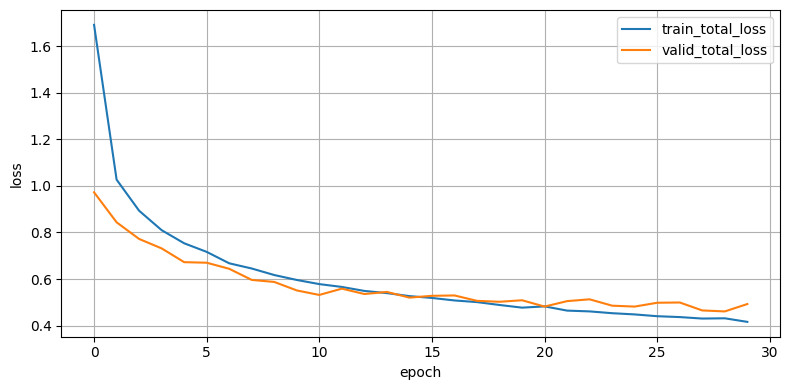

In [85]:
# augmentation 적용
plt.figure(figsize=(8, 4))
plt.plot(t_loss, label = 'train_total_loss')
plt.plot(v_loss, label = 'valid_total_loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

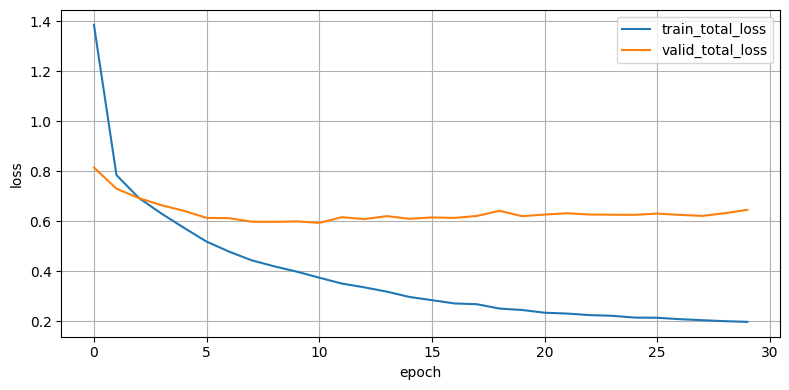

In [ ]:
# normal - augmentation 미적용
# plt.figure(figsize=(8, 4))
# plt.plot(t_loss, label = 'train_total_loss')
# plt.plot(v_loss, label = 'valid_total_loss')

# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.grid("on")
# plt.legend(loc='upper right')
# plt.tight_layout()

## TEST : test data

In [86]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = YOLO_RESNET(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()

    return model

In [ ]:
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [87]:
ckpt_path = '/content/data/trained_model/model_30.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

In [88]:
@torch.no_grad()
def model_predict(image, model, conf_threshold=0.3, iou_threshold=0.1):
    predictions = model(image)
    prediction = predictions.cpu().detach().squeeze(dim=0)

    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE / grid_size

    conf = prediction[[0, 5], ...].reshape(1, -1)
    xc = (prediction[[1, 6], ...] * IMAGE_SIZE + x_grid * stride_size).reshape(1, -1)
    yc = (prediction[[2, 7], ...] * IMAGE_SIZE + y_grid * stride_size).reshape(1, -1)
    w = (prediction[[3, 8], ...] * IMAGE_SIZE).reshape(1, -1)
    h = (prediction[[4, 9], ...] * IMAGE_SIZE).reshape(1, -1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1, 2)

    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0, 1)

    prediction_res[:, 0].clip(min=0)
    prediction_res[:, 1].clip(min=0)
    prediction_res[:, 2].clip(max=IMAGE_SIZE)
    prediction_res[:, 3].clip(max=IMAGE_SIZE)

    pred_res = prediction_res[prediction_res[:, 4] > conf_threshold]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()

    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]

    return bboxes, scores, class_ids

In [89]:
pred_images = []
pred_labels = []

for index, batch in enumerate(dataloaders['test']):
    images = batch[0].to(DEVICE)
    bboxes, scores, class_ids = model_predict(images, model, conf_threshold=0.2, iou_threshold=0.1)

    if len(bboxes) > 0:
        prediction_yolo = np.concatenate([bboxes, scores[:, np.newaxis], class_ids[:, np.newaxis]], axis=1)
    else:
        prediction_yolo = np.array([])

    np_image = make_grid(images[0], normalize=True).cpu().permute(1, 2, 0).numpy()

    pred_images.append(np_image)
    pred_labels.append(prediction_yolo)

In [90]:
@interact(index = (0, len(pred_images)-1))
def show_result(index=0):
    if len(pred_labels[index]) > 0:
        result = utils.visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 5])
    else:
        result = pred_images[index]

    plt.figure(figsize=(6, 6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=1522), Output()), _dom_classes=('widget-inte…

## TEST : test movie

In [91]:
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [92]:
@torch.no_grad()
def model_predict(image, model, conf_threshold=0.3, iou_threshold=0.1):
    tf_data = transform(image=image)
    tensor_image = tf_data['image'].to(DEVICE)
    tensor_image = tensor_image.unsqueeze(dim=0)

    predictions = model(tensor_image)
    prediction = predictions.cpu().detach().squeeze(dim=0)

    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE / grid_size

    conf = prediction[[0, 5], ...].reshape(1, -1)
    xc = (prediction[[1, 6], ...] * IMAGE_SIZE + x_grid * stride_size).reshape(1, -1)
    yc = (prediction[[2, 7], ...] * IMAGE_SIZE + y_grid * stride_size).reshape(1, -1)
    w = (prediction[[3, 8], ...] * IMAGE_SIZE).reshape(1, -1)
    h = (prediction[[4, 9], ...] * IMAGE_SIZE).reshape(1, -1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1, 2)

    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0, 1)

    prediction_res[:, 0].clip(min=0)
    prediction_res[:, 1].clip(min=0)
    prediction_res[:, 2].clip(max=IMAGE_SIZE)
    prediction_res[:, 3].clip(max=IMAGE_SIZE)

    pred_res = prediction_res[prediction_res[:, 4] > conf_threshold]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()

    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]

    return bboxes, scores, class_ids

In [ ]:
# 코렙 버전에서는 확인을 이미지로
from google.colab.patches import cv2_imshow
video_path = '/content/bus-truck.mp4'
output = []
vid = cv2.VideoCapture(video_path)

while (vid.isOpened()):
    ret, frame = vid.read()

    if ret:
        since = time()
        ori_h, ori_w = frame.shape[:2]
        bboxes, scores, class_ids = model_predict(frame, model, conf_threshold=0.2, iou_threshold=0.1)
        text= f"{(time() - since)*1000:.0f}ms/image"

        if len(bboxes) > 0:
            bboxes[:, [0,2]] *= (ori_w/IMAGE_SIZE)
            bboxes[:, [1,3]] *= (ori_h/IMAGE_SIZE)
            bboxes[:, 2].clip(min=0, max=ori_w)
            bboxes[:, 3].clip(min=0, max=ori_h)
            result = utils.visualize(frame, bboxes, class_ids)
        else:
            result = frame

        cv2.putText(result, text, (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2_imshow(result) # colab
        # cv2.imshow('video', result)
        output.append(result)

        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()

vid.release()
cv2.destroyAllWindows()

- video 내보내기 : 영상으로 만들어서 확인해 보자


In [94]:
video_path = '/content/bus-truck.mp4'
cv2.destroyAllWindows()
cap = cv2.VideoCapture(video_path)
img_list = []

if cap.isOpened():

    while True:
        ret, img = cap.read()
        if ret:
            img = cv2.resize(img, (640, 640))
            img_list.append(img)
            # cv2_imshow(img)
            # cv2.waitKey(1)
        else:
            break

cap.release()
cv2.destroyAllWindows()

print('저장된 frame의 개수: {}'.format(len(img_list)))

저장된 frame의 개수: 842


In [95]:
from tqdm import tqdm
out_img_list = []
for frame in tqdm(img_list):
    ori_h, ori_w = frame.shape[:2]
    bboxes, scores, class_ids = model_predict(frame, model, conf_threshold=0.2, iou_threshold=0.1)

    if len(bboxes) > 0:
            bboxes[:, [0,2]] *= (ori_w/IMAGE_SIZE)
            bboxes[:, [1,3]] *= (ori_h/IMAGE_SIZE)
            bboxes[:, 2].clip(min=0, max=ori_w)
            bboxes[:, 3].clip(min=0, max=ori_h)
            result = utils.visualize(frame, bboxes, class_ids)
    else:
        result = frame

    cv2.putText(result, 'YOLO', (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
    out_img_list.append(result)

100%|██████████| 842/842 [00:10<00:00, 82.94it/s]


In [96]:
filename = './output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 25
frameSize = (ori_h, ori_w)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()